# Behavioral Cloning

In [1]:
import os 
import csv
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Lambda
import matplotlib.pyplot as plt
from keras.layers import Cropping2D
from keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint  
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Prepare train_samples and validation_samples

In [2]:
samples = []
with open("./data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

train_samples, validation_samples = train_test_split(samples[1:], test_size=0.2) # The first line of the samples is title, so remove it.

In [3]:
print(len(samples))
print(len(train_samples))
print(len(validation_samples))

8037
6428
1608


## Define the generator to avoid out of memory exception and preprocess images

### the preprocess steps contains:
- convert the BGR image to RGB image
- apply correction parameter to the angle of left image and right image
- flip the center image

In [4]:
def generator(samples, batch_size=32):
    correction = 0.25 # the parameter to tune for left image and right image
    num_samples = len(samples)
    while 1:
        shuffle(samples) # shuffle data
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_name = "./data/IMG/" + batch_sample[0].split('/')[-1]
                left_name = "./data/IMG/" + batch_sample[1].split('/')[-1]
                right_name = "./data/IMG/" + batch_sample[2].split('/')[-1]
                center_image = cv2.imread(center_name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                left_image = cv2.imread(left_name)
                left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
                right_image = cv2.imread(right_name)
                right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
                center_angle = float(batch_sample[3])                
                steering_left = center_angle + correction
                steering_right = center_angle - correction
                images.append(center_image)
                angles.append(center_angle)
                images.append(np.fliplr(center_image))
                angles.append(-center_angle)
                images.append(left_image)
                angles.append(steering_left)
                images.append(right_image)
                angles.append(steering_right)
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [5]:
train_generator = generator(train_samples, batch_size=4)
validation_generator = generator(validation_samples, batch_size=4)

## Define the model
- normalize the image first
- crop the top and bottom lines in order to reduce unrelated information
- use dropout to avoid overfitting
- the specific structure of the model is showed by model.summary() after the next cell

In [7]:
row, col, ch = 160, 320, 3
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(row, col, ch)))
model.add(Cropping2D(cropping=((60,10), (0,0))))
model.add(Convolution2D(32,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(64,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(64,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(16,5,5, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(1024, activation="linear"))
model.add(Dropout(0.5))
model.add(Dense(512, activation="linear"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 86, 316, 32)   2432        cropping2d_1[0][0]               
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 43, 158, 32)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

## Use adam optimizer and save the model to model.h5

In [8]:
checkpointer = ModelCheckpoint(filepath='model.h5', 
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=
            len(train_samples)*4, validation_data=validation_generator,
            nb_val_samples=len(validation_samples), nb_epoch=7, callbacks=[checkpointer,early_stopping])


Epoch 1/7
25712/25712 [==============================] - 77s - loss: 0.0266 - val_loss: 0.0242
Epoch 2/7
25712/25712 [==============================] - 73s - loss: 0.0218 - val_loss: 0.0235
Epoch 3/7
25712/25712 [==============================] - 73s - loss: 0.0210 - val_loss: 0.0200
Epoch 4/7
25712/25712 [==============================] - 73s - loss: 0.0202 - val_loss: 0.0169
Epoch 5/7
25712/25712 [==============================] - 73s - loss: 0.0196 - val_loss: 0.0200
Epoch 6/7
25712/25712 [==============================] - 73s - loss: 0.0193 - val_loss: 0.0188
Epoch 7/7
25712/25712 [==============================] - 73s - loss: 0.0186 - val_loss: 0.0171


## Visualize the error loss

dict_keys(['val_loss', 'loss'])


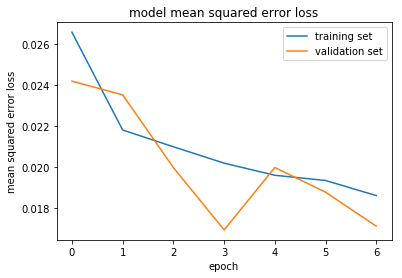

In [9]:
#model.save('model.h5')
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()